https://iter01.com/511487.html

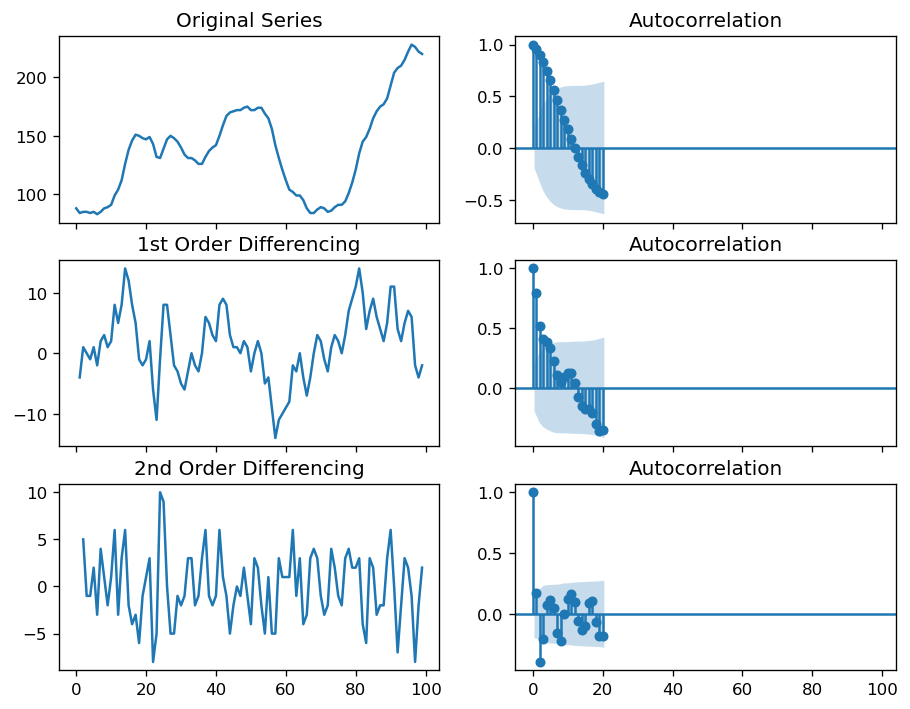

In [11]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data : Internet Usage per Minute
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

# 構建ARIMA模型
- conda install -c conda-forge statsmodels

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 05 Apr 2021   AIC                            517.579
Time:                        14:52:37   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.value     0.5287      0.355     

＃ 檢查殘差

- 通常會檢查模型擬合的殘差序列，即訓練資料原本的序列減去訓練資料上的擬合序列後的序列。該序列越符合隨機誤差分佈(均值為0的正態分佈)，說明模型擬合的越好，否則，說明還有一些因素模型未能考慮

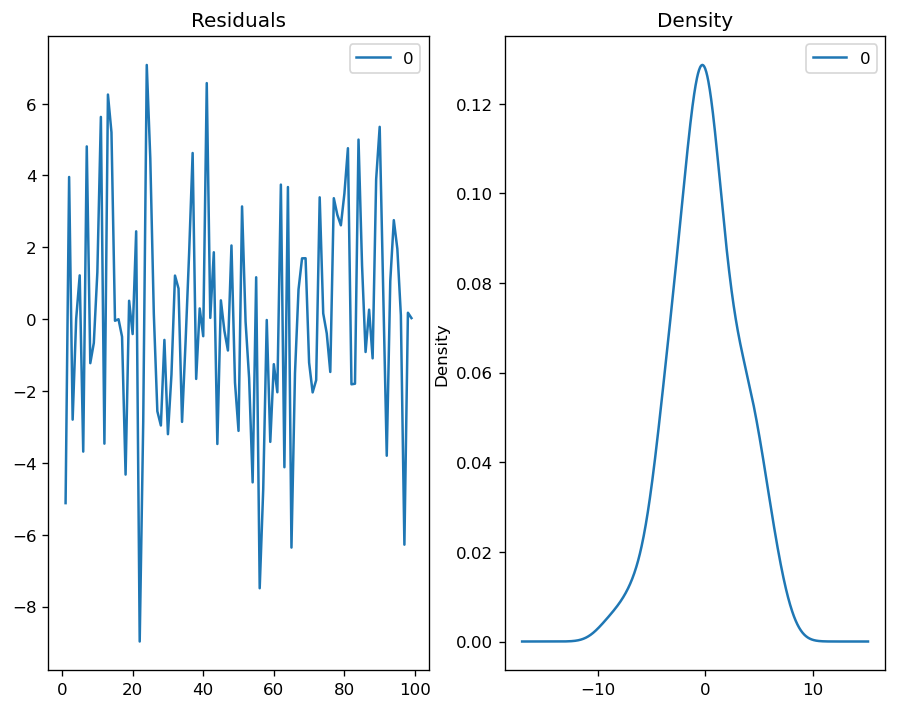

In [13]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# 模型擬合

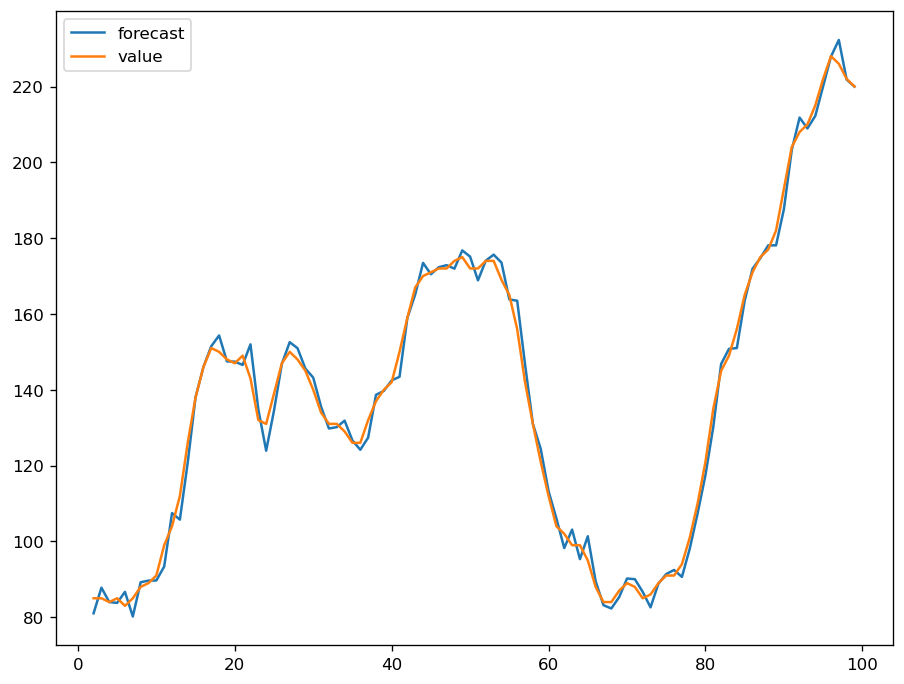

In [14]:

# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

# 模型預測

除了在訓練資料上擬合，一般都會預留一部分時間段作為模型的驗證，這部分時間段的資料不參與模型的訓練。

In [15]:
#這是在ARIMA(1,1,1)下的預測結果，
# 給出了一定的序列變化方向，看上去還是可以的。
# 不過所有的預測值，都在真實值以下，所以還可以試試看有沒有別的更好的階陣列合。
# 其實如果嘗試用ARIMA(3,2,1)會發現預測的更好：

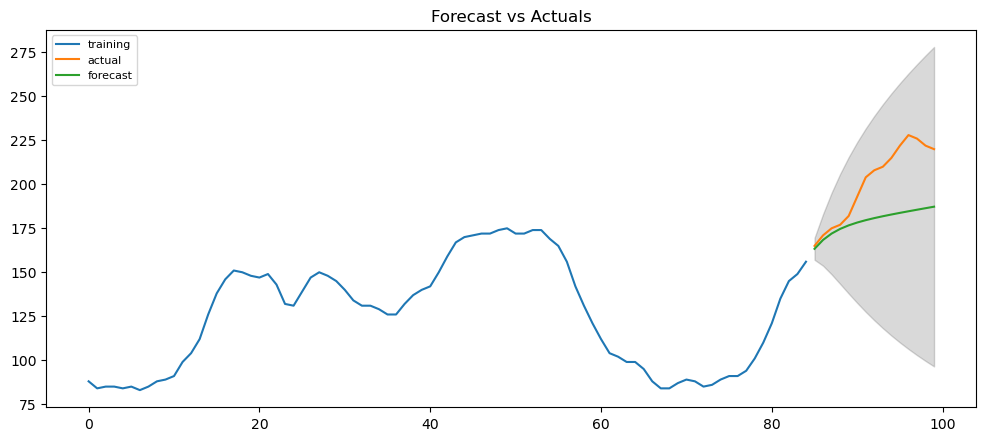

In [16]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# AUTO ARIMA

通過預測結果來推斷模型階數的好壞畢竟還是耗時耗力了些，一般可以通過計算AIC或BIC的方式來找出更好的階陣列合。pmdarima模組的auto_arima方法就可以讓我們指定一個階數上限和資訊準則計算方法，從而找到資訊準則最小的階陣列合。

In [19]:
import pmdarima as pm

ImportError: cannot import name 'iterkeys' from 'statsmodels.compat.python' (/Users/lokcyi/opt/anaconda3/envs/python37/lib/python3.7/site-packages/statsmodels/compat/python.py)

In [17]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pandas.util._decorators import Appender

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

ImportError: cannot import name 'iterkeys' from 'statsmodels.compat.python' (/Users/lokcyi/opt/anaconda3/envs/python37/lib/python3.7/site-packages/statsmodels/compat/python.py)

In [ ]:
# 上節介紹的auto arima的程式碼中，seasonal引數設為了false，構建季節性模型的時候，把該引數置為True，然後對應的P，D，Q,m引數即可，程式碼如下：
# conda install -c conda-forge pmdarima 

In [ ]:
# !pip3 install pyramid-arima
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

In [ ]:
def load_data():
    """
    航司乘客數時間序列資料集
    該資料集包含了1949-1960年每個月國際航班的乘客總數。
    """
    from datetime import datetime
    date_parse = lambda x: datetime.strptime(x, '%Y-%m-%d')
    data = pd.read_csv('https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv', index_col='Month', parse_dates=['Month'], date_parser=date_parse)
    # print(data)
    # print(data.index)
    ts = data['value']
    # print(ts.head(10))
    # plt.plot(ts)
    # plt.show()
    return ts,data

# 載入時間序列資料
_ts,_data = load_data()
# 時間序列分解
result_mul = seasonal_decompose(_ts[-36:],  # 3 years
                                model='multiplicative',
                                freq=12,
                                extrapolate_trend='freq')
_seasonal_frame = result_mul.seasonal[-12:].to_frame()
_seasonal_frame['month'] = pd.to_datetime(_seasonal_frame.index).month
# seasonal_index = result_mul.seasonal[-12:].index
# seasonal_index['month'] = seasonal_index.month.values
print(_seasonal_frame)
_data['month'] = _data.index.month
print(_data)
_df = pd.merge(_data, _seasonal_frame, how='left', on='month')
_df.columns = ['value', 'month', 'seasonal_index']
print(_df)
print(_df.index)
_df.index = _data.index  # reassign the index.
print(_df.index)

build_arima(_df,_seasonal_frame,_data)

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']],
						exogenous=df[['seasonal_index']],
						start_p=1, start_q=1,
						test='adf',
						max_p=3, max_q=3, m=12,
						start_P=0, seasonal=False,
						d=1, D=1, trace=True,
						error_action='ignore',
						suppress_warnings=True,
						stepwise=True)
sxmodel.summary()
# Forecast
n_periods = 36
fitted, confint = sxmodel.predict(n_periods=n_periods,
								  exogenous=np.tile(seasonal_frame['y'].values, 3).reshape(-1, 1),
								  return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['y'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
				 lower_series,
				 upper_series,
				 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

https://www.uj5u.com/qita/14677.html

In [ ]:
# coding='utf-8'
"""
航司乘客數時間序列資料集
該資料集包含了1949-1960年每個月國際航班的乘客總數，
"""
import numpy as np
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

params = {'font.family': 'serif',
          'font.serif': 'FangSong',
          'font.style': 'italic',
          'font.weight': 'normal',  # or 'blod'
          'font.size': 12,  # 此處貌似不能用類似large、small、medium字串
          'axes.unicode_minus': False
          }
rcParams.update(params)
import matplotlib.pyplot as plt
import pandas as pd
# 未來pandas版本會要求顯式注冊matplotlib的轉換器，所以添加了下面兩行代碼，否則會報警告
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


def load_data():
    from datetime import datetime
    date_parse = lambda x: datetime.strptime(x, '%Y-%m-%d')
    data = https://www.cnblogs.com/anai/p/pd.read_csv('datas/samples/AirPassengers.csv',
                       index_col='Month',  # 指定索引列
                       parse_dates=['Month'],  # 將指定列按照日期格式來決議
                       date_parser=date_parse  # 日期格式決議器
                       )
    ts = data['y']
    print(ts.head(10))
    plt.plot(ts)
    plt.show()
    return ts


def use_rolling_statistics(time_series_datas):
    '''
    利用標準差和均值來肉眼觀測時間序列資料的平穩情況
    :param time_series_datas:
    :return:
    '''
    roll_mean = time_series_datas.rolling(window=12).mean()
    roll_std = time_series_datas.rolling(window=12).std()
    # roll_variance = time_series_datas.rolling(window=12).var()
    plt.plot(time_series_datas, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='green', label='Rolling Std')
    # plt.plot(roll_variance,color='yellow',label='Rolling Variance')

    plt.legend(loc='best')
    plt.title('利用Rolling Statistics來觀測時間序列資料的平穩情況')
    plt.show(block=False)


def use_df(time_series_datas):
    '''
    迪基-富勒單位根檢驗
    :param time_series_datas:
    :return:
    '''
    from statsmodels.tsa.stattools import adfuller
    dftest = adfuller(time_series_datas, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def use_moving_avg(ts_log):
    moving_avg_month = ts_log.rolling(window=12).mean()
    plt.plot(moving_avg_month, color='green', label='moving_avg')
    plt.legend(loc='best')
    plt.title('利用移動平均法平滑ts_log序列')
    plt.show()
    return moving_avg_month


def use_exponentially_weighted_moving_avg(ts_log):
    expweighted_avg = ts_log.ewm(halflife=12).mean()
    plt.plot(expweighted_avg, color='green', label='expweighted_avg')
    plt.legend(loc='best')
    plt.title('利用指數加權移動平均法平滑ts_log序列')
    plt.show()
    return expweighted_avg


def use_decomposition(ts_log):
    '''
    時間序列分解
    :param ts_log:
    :return: 去除不平穩因素后的序列
    '''
    decomposition = seasonal_decompose(ts_log, freq=12)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    # 衡量趨勢強度
    r_var = residual.var()
    tr_var = (trend + residual).var()
    f_t = np.maximum(0, 1.0 - r_var / tr_var)
    print(f_t)
    # 衡量季節性強度
    sr_var = (seasonal + residual).var()
    f_s = np.maximum(0, 1.0 - r_var / sr_var)
    print(f"-------趨勢強度:{f_t},季節性強度:{f_s}------")
    return residual


def transform_stationary(ts):
    '''
    平穩變換：
    消除趨勢：移動平均、指數加權移動平均
    有時候簡單的減掉趨勢的方法并不能得到平穩序列，尤其對于高季節性的時間序列來說，此時可以采用differencing(差分)或decomposition(分解)
    消除趨勢和季節性：差分、序列分解
    :param ts:
    :return:
    '''
    # 利用log降低異方差性
    ts_log = np.log(ts)
    # plt.plot(ts_log, color='brown', label='ts_log')
    # plt.title('ts_log')
    # plt.show()

    # 移動平均法，得到趨勢（需要確定合適的K值，當前例子中，合適的K值是12個月，因為趨勢是逐年增長，但是有些復雜場景下，K值的確定很難）
    # trend = use_moving_avg(ts_log)
    # 指數加權移動平均法平，得到趨勢(由于每次都是從當前時刻到起始時刻的指數加權平均，所以沒有確定K值的問題)
    # trend = use_exponentially_weighted_moving_avg(ts_log)
    # print(trend)
    # 減去趨勢：將平滑后的序列從ts_log序列中移除
    # rs = ts_log - trend
    # 若趨勢建模是用的移動平均法，由于是取前12個月的均值，所以開始的11個值的移動平均都是非數了，需要去除非數
    # rs.dropna(inplace=True)

    # differencing(差分)
    rs_log_diff = ts_log - ts_log.shift()  # 1階差分
    # use_rolling_statistics(rs)
    # rs = rs - rs.shift() # 2階差分
    # 季節性差分 ,此案例中的季節間隔為12個月  d=1 D=1
    # rs = (ts_log - ts_log.shift(periods=12)) - (ts_log.shift() - ts_log.shift().shift(periods=12))
    rs_log_diff.dropna(inplace=True)

    # decomposition(分解)
    # rs = use_decomposition(ts_log)
    # rs.dropna(inplace=True)

    # 對去除趨勢后的序列做平穩性檢驗
    # use_rolling_statistics(rs)
    use_df(rs_log_diff)
    return ts_log, rs_log_diff


def order_determination(ts_log_diff):
    '''
    利用acf和pacf確定模型以及階數
    :param ts_log_diff:
    :return:
    '''
    lag_acf = acf(ts_log_diff, nlags=10, fft=False)
    lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')
    z = 1.96
    # z = 1.65
    # Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-z / np.sqrt(len(ts_log_diff) - 1), linestyle='--',
                color='gray')  # 利用白噪聲的標準正態分布假設來選擇相關性的置信度區間，1.96是95%置信度下的統計量
    plt.axhline(y=z / np.sqrt(len(ts_log_diff) - 1), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')
    # Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-z / np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
    plt.axhline(y=z / np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()


def draw_rss_plot(ts_log_diff, orders, title, freq='MS'):
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(ts_log_diff, order=orders, freq=freq)
    results_fitted = model.fit(disp=-1)
    # print(results.summary())
    plt.plot(ts_log_diff)
    plt.plot(results_fitted.fittedvalues, color='red')
    plt.title('%s RSS: %.4f' % (title, sum((results_fitted.fittedvalues - ts_log_diff) ** 2)))
    plt.show()
    return results_fitted.fittedvalues


def draw_future_plot(ts_log_diff, orders, seasonal_order, title, freq='MS'):
    # ARIMA模型
    # model = ARIMA(ts_log_diff, order=orders, freq=freq)
    # results_fitted = model.fit(disp=-1, trend='c')
    # fit_values = results_fitted.fittedvalues
    # fc, _, conf = results_fitted.forecast(36, alpha=0.05)  # 95% conf

    # 季節性ARIMA模型
    model = SARIMAX(ts_log_diff, order=orders, seasonal_order=seasonal_order)
    results_fitted = model.fit(disp=5)
    fit_values = results_fitted.fittedvalues
    print(results_fitted.summary())
    fc = results_fitted.forecast(36)
    conf = None

    return fit_values, fc, conf, title


def build_arima(ts_log_diff):
    '''
    start_params表示ARIMA模型的所有項的引數，包括常數項，AR階數項，MA階數項，隨機誤差項.
    '''
    # order = (0, 1, 0) # 僅能靠常數的逆差分構建一個趨勢,這里的常數是start_params的第一個元素，是通過一個全一的exog列向量和一個endog列向量做OLS方法得到的一個常數，這個常數其實就是endog向量元素的平均值
    # order = (3, 1, 0) # 逆差分構建一個趨勢 + 變數自回歸擬合一定的波動
    # order = (0, 1, 3) # 逆差分構建一個趨勢 + 隨機誤差自回歸擬合一定的波動，誤差應該是來自平均值作為預測的誤差，待求證
    order = (3, 0, 2)  # 變數自回歸擬合一定的波動 + 預測誤差自回歸擬合一定的波動
    seasonal_order = (0, 1, 0, 12)  # 季節性差分，季節視窗=12個月

    # draw_rss_plot(ts_log_diff, order, '擬合：%s' % str(order))

    fittedvalues, fc, conf, title = draw_future_plot(ts_log_diff, order, seasonal_order,
                                                     '預測：%s,%s' % (str(order), str(seasonal_order)))
    return fittedvalues, fc, conf, title


def transform_back(ts, fittedvalues, fc, conf, title):
    '''
    變換回平穩變換之前的狀態，以便預測目標觀測值
    :param ts: 原始序列
    :param fittedvalues: 擬合出的序列
    :param fc: 預測的未來序列
    :return:
    '''
    # Make as pandas series
    future_index = pd.date_range(start=ts.index[-1], freq='MS', periods=36)
    fc_series = pd.Series(fc, index=future_index)
    print(fc_series.head())
    print(fittedvalues.head(24))
    lower_series, upper_series = None, None
    if conf is not None:
        lower_series = pd.Series(conf[:, 0], index=future_index)
        upper_series = pd.Series(conf[:, 1], index=future_index)

    current_ARIMA_log = pd.Series(fittedvalues, copy=True)
    future_ARIMA_log = pd.Series(fc_series, copy=True)

    # 逆log
    current_ARIMA = np.exp(current_ARIMA_log)
    future_ARIMA = np.exp(future_ARIMA_log)
    # lower_ARIMA = np.exp(lower_log_series)
    # upper_ARIMA = np.exp(upper_log_series)
    # Plot
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(ts, label='current_actual')
    plt.plot(current_ARIMA, label='current_fit')
    plt.plot(future_ARIMA, label='forecast', marker='o', ms=3)
    if lower_series is not None:
        # plt.fill_between(lower_ARIMA.index, lower_ARIMA, upper_ARIMA,color='k', alpha=.15)
        pass
    plt.title('Forecast vs Actuals %s' % title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


def plot_lag(rs):
    from pandas.plotting import lag_plot
    fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        lag_plot(rs, lag=i + 1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i + 1))

    fig.suptitle('Lag Plots of AirPassengers', y=1.15)
    plt.show()
    
def SampEn(U, m, r):
    """
    Compute Sample entropy
    用于量化時間序列的可預測性
    思想：
    回傳一個-np.log(A/B)，該值越小預測難度越小，所以A/B越大，預測難度越小，
    :param U: 時間序列
    :param m: 模板向量維數
    :param r: 距離容忍度，一般取0.1~0.25倍的時間序列標準差，也可以理解為相似度的度量閾值，小于這個閾值的2個向量被認為是相似的
    :return: 回傳一個-np.log(A/B)，該值越小預測難度越小，所以A/B越大，預測難度越小， 一般可以和同等長度的隨機序列的結果比較，小于這個結果，則具備一定的可預測性
    """

    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m + 1) / _phi(m))


if __name__ == '__main__':
    # 加載時間序列資料
    _ts = load_data()
    # 使用樣本熵評估可預測性
    print(f'原序列樣本熵:{SampEn(_ts.values, m=2, r=0.2 * np.std(_ts.values))}')
    # 檢驗平穩性
    use_rolling_statistics(_ts)  # rolling 肉眼
    use_df(_ts)  # Dickey-Fuller Test 量化
    # 平穩變換
    _ts_log, _rs_log_diff = transform_stationary(_ts)
    # 使用樣本熵評估可預測性
    print(f'平穩變換后的序列樣本熵:{SampEn(_ts.values, m=2, r=0.2 * np.std(_ts.values))}')
    # acf,pacf定階分析
    order_determination(_rs_log_diff)
    # plot_lag(_rs)# lag plot(滯后圖分析相關性)
    # 構建模型
    _fittedvalues, _fc, _conf, _title = build_arima(
        _ts_log)  # 這里只傳取log后的序列是因為后面會通過指定ARIMA模型的引數d=1來做一階差分，這樣在預測的時候，就不需要手動做逆差分來還原序列，而是由ARIMA模型自動還原
    # 預測,并繪制預測結果圖
    transform_back(_ts, _fittedvalues, _fc, _conf, _title)